C:\Users\RohitChopra\AppData\Local\Temp\ipykernel_1244\1975149466.py:19: FutureWarning: The default value of numeric_only in DataFrame.median is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  data = data.fillna(data.median())


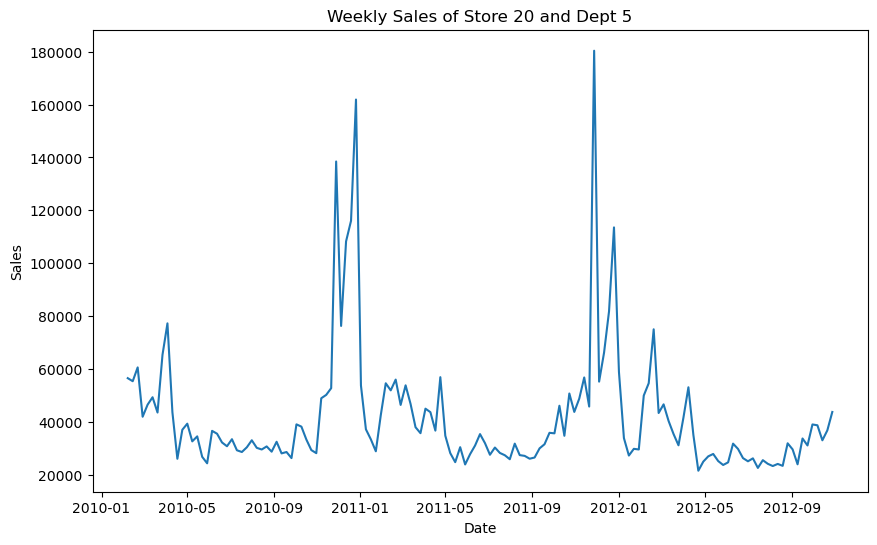



Epoch 1/50

7/7 [==============================] - 7s 215ms/step - loss: 0.0367 - val_loss: 0.0031
Epoch 2/50
7/7 [==============================] - 0s 25ms/step - loss: 0.0309 - val_loss: 0.0101
Epoch 3/50
7/7 [==============================] - 0s 25ms/step - loss: 0.0272 - val_loss: 0.0066
Epoch 4/50
7/7 [==============================] - 0s 26ms/step - loss: 0.0263 - val_loss: 0.0042
Epoch 5/50
7/7 [==============================] - 0s 23ms/step - loss: 0.0261 - val_loss: 0.0041
Epoch 6/50
7/7 [==============================] - 0s 24ms/step - loss: 0.0274 - val_loss: 0.0040
Epoch 7/50
7/7 [==============================] - 0s 23ms/step - loss: 0.0260 - val_loss: 0.0046
Epoch 8/50
7/7 [==============================] - 0s 25ms/step - loss: 0.0258 - val_loss: 0.0051
Epoch 9/50
7/7 [==============================] - 0s 22ms/step - loss: 0.0259 - val_loss: 0.0040
Epoch 10/50
7/7 [==============================] - 0s 22ms/step - loss: 0.0260 - val_loss: 0.0037
Epoch 11/50
7/7 [========

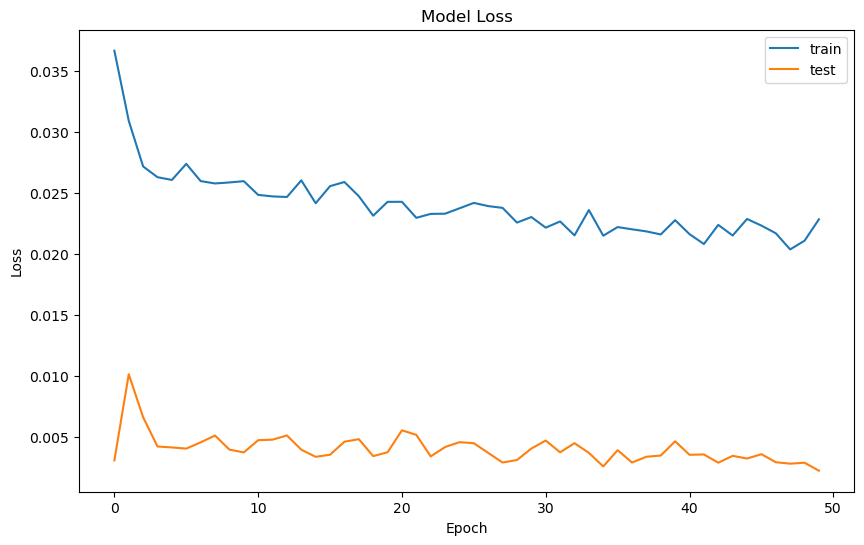

1/1 [==============================] - 1s 1s/step


ValueError: Found array with dim 3. None expected <= 2.

In [8]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout

# Load and merge the datasets
train = pd.read_csv('train.csv')
features = pd.read_csv('features.csv')
stores = pd.read_csv('stores.csv')
data = pd.merge(train, features, on=['Store','Date','IsHoliday'], how='inner')
data = pd.merge(data, stores, on=['Store'], how='inner')

# Fill the missing values with median
data = data.fillna(data.median())

# Convert the Date column to datetime format and set it as index
data['Date'] = pd.to_datetime(data['Date'])
data = data.set_index('Date')

# Aggregate the weekly sales by store and department
weekly_sales = data.groupby(['Store','Dept'])['Weekly_Sales'].resample('W').sum()

# Select a sample store and department for demonstration
sample_sales = weekly_sales.loc[20,5]

# Plot the sample sales data
plt.figure(figsize=(10,6))
plt.plot(sample_sales)
plt.title('Weekly Sales of Store 20 and Dept 5')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.show()

# Scale the data using MinMaxScaler
scaler = MinMaxScaler()
scaled_sales = scaler.fit_transform(sample_sales.values.reshape(-1,1))

# Define a function to create the input and output sequences for the model
def create_sequences(data, window_size, horizon):
  X = []
  y = []
  for i in range(len(data) - window_size - horizon + 1):
    X.append(data[i:i+window_size])
    y.append(data[i+window_size:i+window_size+horizon])
  return np.array(X), np.array(y)

# Create the input and output sequences with a window size of 12 and a horizon of 1
window_size = 12
horizon = 1
X, y = create_sequences(scaled_sales, window_size, horizon)

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Reshape the data to 3D format for LSTM layer
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# Define the deep neural network model using Keras
model = Sequential()
model.add(LSTM(32, input_shape=(window_size, 1), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(16, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(horizon))

# Compile the model
model.compile(loss='mse', optimizer='adam')

# Fit the model on the train data
history = model.fit(X_train, y_train, epochs=50, batch_size=16, validation_data=(X_test, y_test), verbose=1)

# Plot the learning curves
plt.figure(figsize=(10,6))
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Predict the sales on the test data
y_pred = model.predict(X_test)

# Rescale the data back to the original scale
y_pred = scaler.inverse_transform(y_pred)
y_test = scaler.inverse_transform(y_test)

# Plot the predicted vs actual sales
plt.figure(figsize=(10,6))
plt.plot(y_test, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.title('Weekly Sales Prediction')
plt.xlabel('Weeks')
plt.ylabel('Sales')
plt.legend()
plt.show()

# Evaluate the model performance using RMSE and R2 score
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
print('RMSE: ', rmse)
print('R2 Score: ', r2)
